In [35]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import googletrans
import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [36]:
data = pd.read_csv("../Data/HateSpeechText.csv",sep=";",encoding="latin-1")
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [37]:
data.shape

(13169, 13)

## Data Analysis

### Perbandingan jumlah tiap label

In [38]:
label_size0 = []
label_size1 = []

for i in data.columns[1:]:
    label_size0.append(len(data[data[i]==0]))
    label_size1.append(len(data[data[i]==1]))

In [39]:
dat_anls = pd.DataFrame({
    'label' : data.columns[1:],
    'negative' : label_size0,
    'positive' : label_size1
})

dat_anls = dat_anls.set_index(['label'], drop=True)

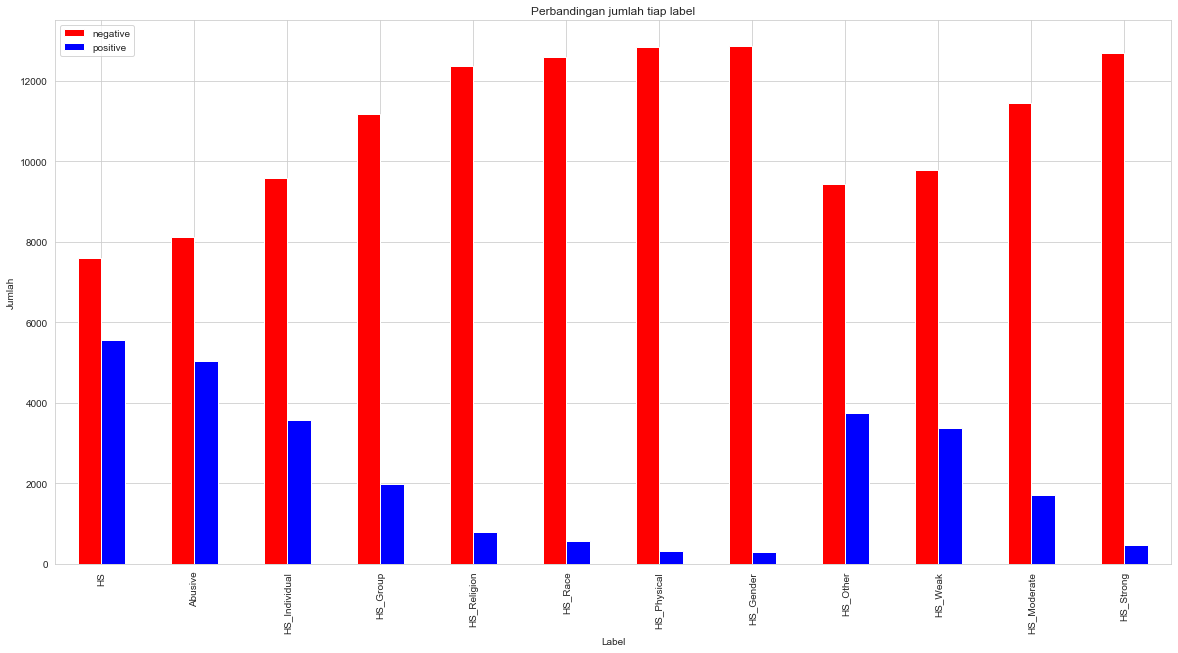

In [40]:
dat_anls.loc[:,['negative','positive']].plot.bar(color=['red','blue'], figsize=(20,10))
plt.title("Perbandingan jumlah tiap label")
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

In [41]:
dat_anls

,negative,positive
label,,
HS,7608,5561
Abusive,8126,5043
HS_Individual,9594,3575
HS_Group,11183,1986
HS_Religion,12376,793
HS_Race,12603,566
HS_Physical,12846,323
HS_Gender,12863,306
HS_Other,9429,3740


### Multiple labels per tweet

Text(0.5, 0, '# of labels')

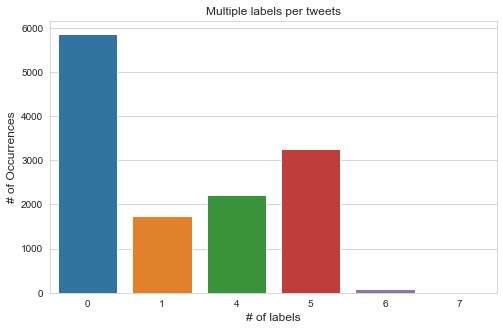

In [42]:
rowsums = data.iloc[:,1:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple labels per tweets")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of labels', fontsize=12)

In [43]:
data.iloc[:,1:].sum(axis=1).value_counts()

0    5860
5    3251
4    2208
1    1748
6      95
7       7
dtype: int64

### Distribusi Panjang Karakter Tweet

In [44]:
data_anl = data[["Tweet"]].copy()

In [45]:
data_anl['Tweet_length'] = data_anl['Tweet'].str.len()

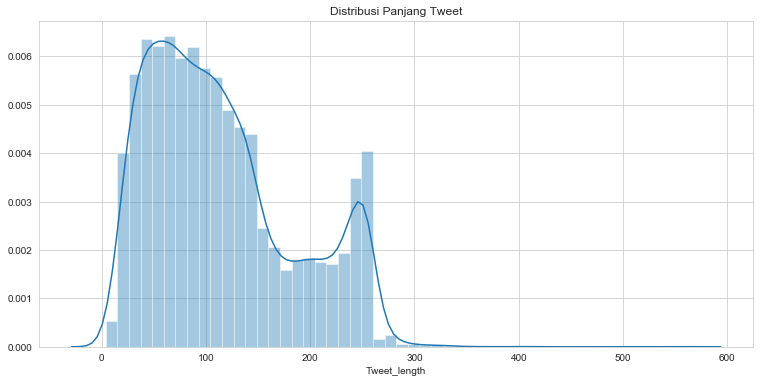

In [46]:
plt.figure(figsize=(12.8,6))
sns.distplot(data_anl['Tweet_length']).set_title('Distribusi Panjang Tweet');

In [47]:
data_anl['Tweet_length'].describe()

count    13169.00000
mean       114.21786
std         69.09064
min          4.00000
25%         59.00000
50%        100.00000
75%        152.00000
max        561.00000
Name: Tweet_length, dtype: float64

### Distribusi Panjang Kata Tweet

In [48]:
data_anl['word_count'] = data_anl['Tweet'].apply(lambda x: len(str(x).split()))

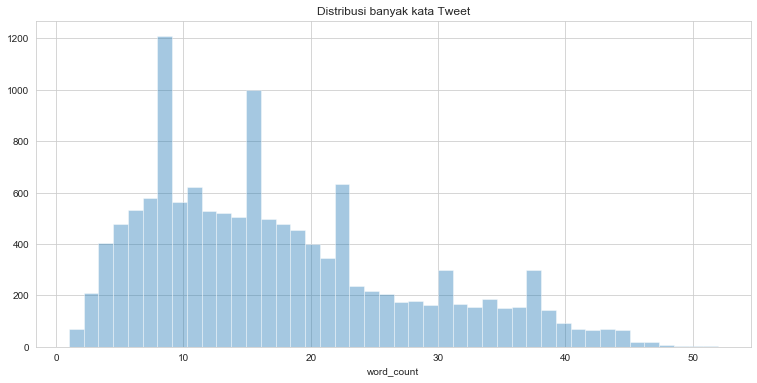

In [49]:
plt.figure(figsize=(12.8,6))
sns.distplot(data_anl['word_count'],kde=False).set_title('Distribusi banyak kata Tweet');

In [50]:
data_anl['word_count'].describe()

count    13169.000000
mean        17.275344
std         10.225917
min          1.000000
25%          9.000000
50%         15.000000
75%         23.000000
max         52.000000
Name: word_count, dtype: float64

### Sampel Tweet

In [51]:
data['Tweet'].iloc[0]

"- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'"

### Top 20 Words

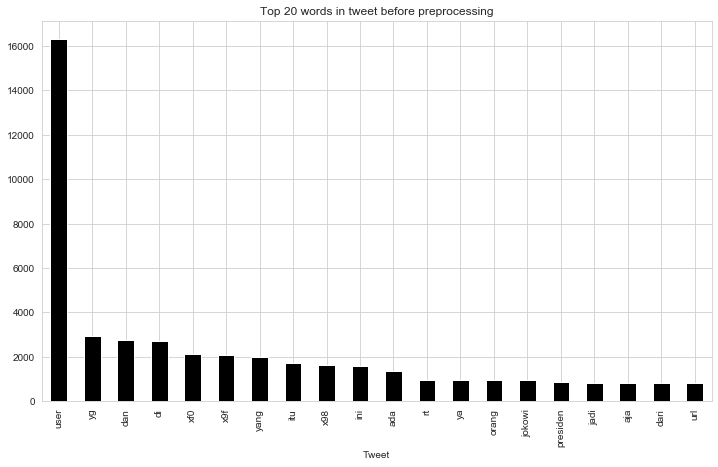

In [52]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data_anl['Tweet'], 20)
# for word, freq in common_words:
#     print(word, freq)
topWord = pd.DataFrame(common_words, columns = ['Tweet' , 'count'])
topWord.groupby('Tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', y='Count', color='black', title='Top 20 words in tweet before preprocessing', figsize=(12,7))


### Top 20 Bigram

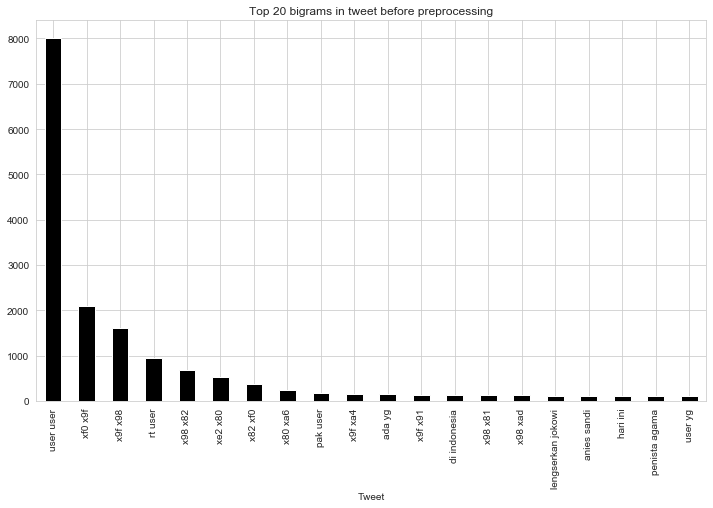

In [53]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(data_anl['Tweet'], 20)
# for word, freq in common_words:
#     print(word, freq)
topbigram = pd.DataFrame(common_words, columns = ['Tweet' , 'count'])
topbigram.groupby('Tweet').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', y='Count', color='black', title='Top 20 bigrams in tweet before preprocessing', figsize=(12,7))


### Language of Words

In [54]:
words = get_top_n_words(data_anl['Tweet'])

In [55]:
lang_count = {}
for i in tqdm(words):
    translator = googletrans.Translator()
    lang = translator.translate(i[0]).src
    lang_amount = i[1]
    if lang not in lang_count.keys():
        lang_count[lang] = lang_amount
    else:
        lang_count[lang] = lang_count[lang]+lang_amount
    time.sleep(2)

  0%|                                                                            | 41/28801 [01:31<17:46:54,  2.23s/it]

KeyboardInterrupt: 

## Store Train and Test Set

In [56]:
X = data[['Tweet']]
y = data.drop(['Tweet'],axis = 1).values

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

In [58]:
data_train = X_train.copy()
data_train = data_train.reset_index(drop=True).join(pd.DataFrame(data=y_train, columns = data.columns[1:]))
data_train.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,Lengserkan kenapa om.. dpr kan punya kuasa rak...,1,0,1,0,0,0,0,0,1,0,0,1
1,Presiden Joko Widodo (Jokowi) meminta agar Sis...,0,0,0,0,0,0,0,0,0,0,0,0
2,luggage semua harga yahudi \xf0\x9f\x98\xb9',0,0,0,0,0,0,0,0,0,0,0,0
3,Pegimana ini? Ã°?Â¤Â­ RT USER: Menarik!; ; Mes...,0,0,0,0,0,0,0,0,0,0,0,0
4,makanya drpd pusing cari yg sdh hilang..mendin...,1,0,1,0,0,0,0,0,1,1,0,0


In [59]:
data_test = X_test.copy()
data_test = data_test.reset_index(drop=True).join(pd.DataFrame(data=y_test, columns = data.columns[1:]))
data_test.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,USER USER Ewe ewe berhadiah',0,1,0,0,0,0,0,0,0,0,0,0
1,"Pada tahun 2045, Indonesia diprediksikan mjd n...",0,0,0,0,0,0,0,0,0,0,0,0
2,"Ini baru ""BERITA""; ; PPP TOLAK PENCAPRESAN JOK...",0,0,0,0,0,0,0,0,0,0,0,0
3,"USER, Resident Country Director USER: Pertumbu...",0,0,0,0,0,0,0,0,0,0,0,0
4,UMAT HINDU SAMPAIKAN SELAMAT ULANG TAHUN KEPAD...,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
data_train.to_csv("../Data/data_train.csv", index=False, sep=";")
data_test.to_csv("../Data/data_test.csv", index=False, sep=";")